# Thin Plasma Lens 3

In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
from numpy.fft import fft, ifft, fftfreq, fftshift
from beam import interactions
from beam.beams import laserbeam
from beam.beams import laserpulse
from beam.elements import optic
from beam.elements import plasma
from propagation import laser
from ionization import ionization
from lens import design
from lens import bessel
from lens import ray
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.style.use('presentation')

path = '/mnt/md0/Data/rariniello/TPL/TPL_3/'
lam = 0.796
tau = 70
# All length units are in um

Attempt to make a thin plasma lens using a rectangular beam diffuser.

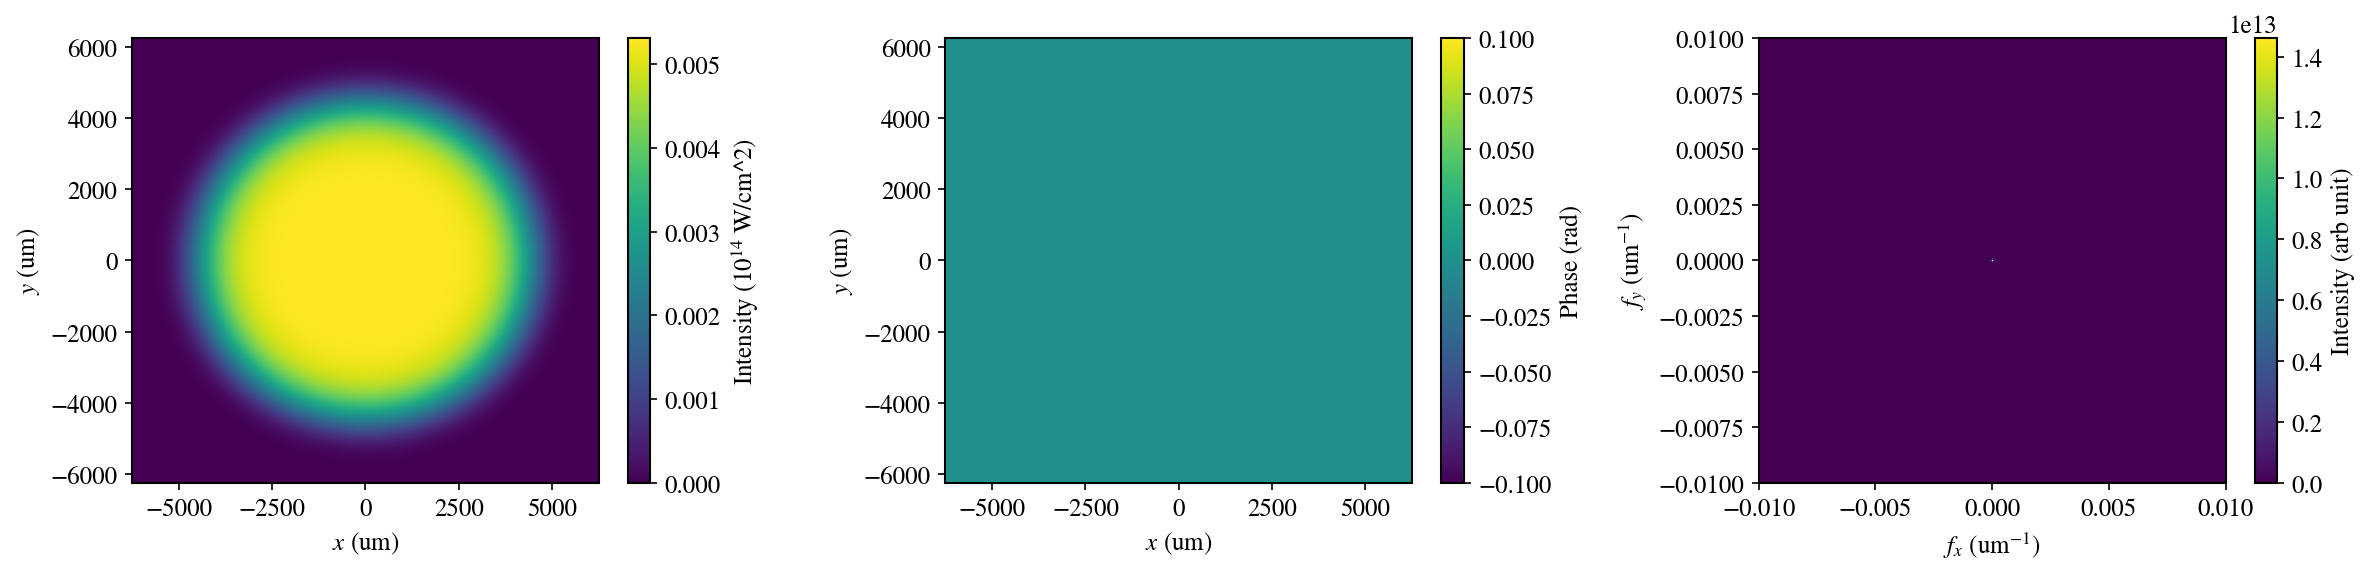

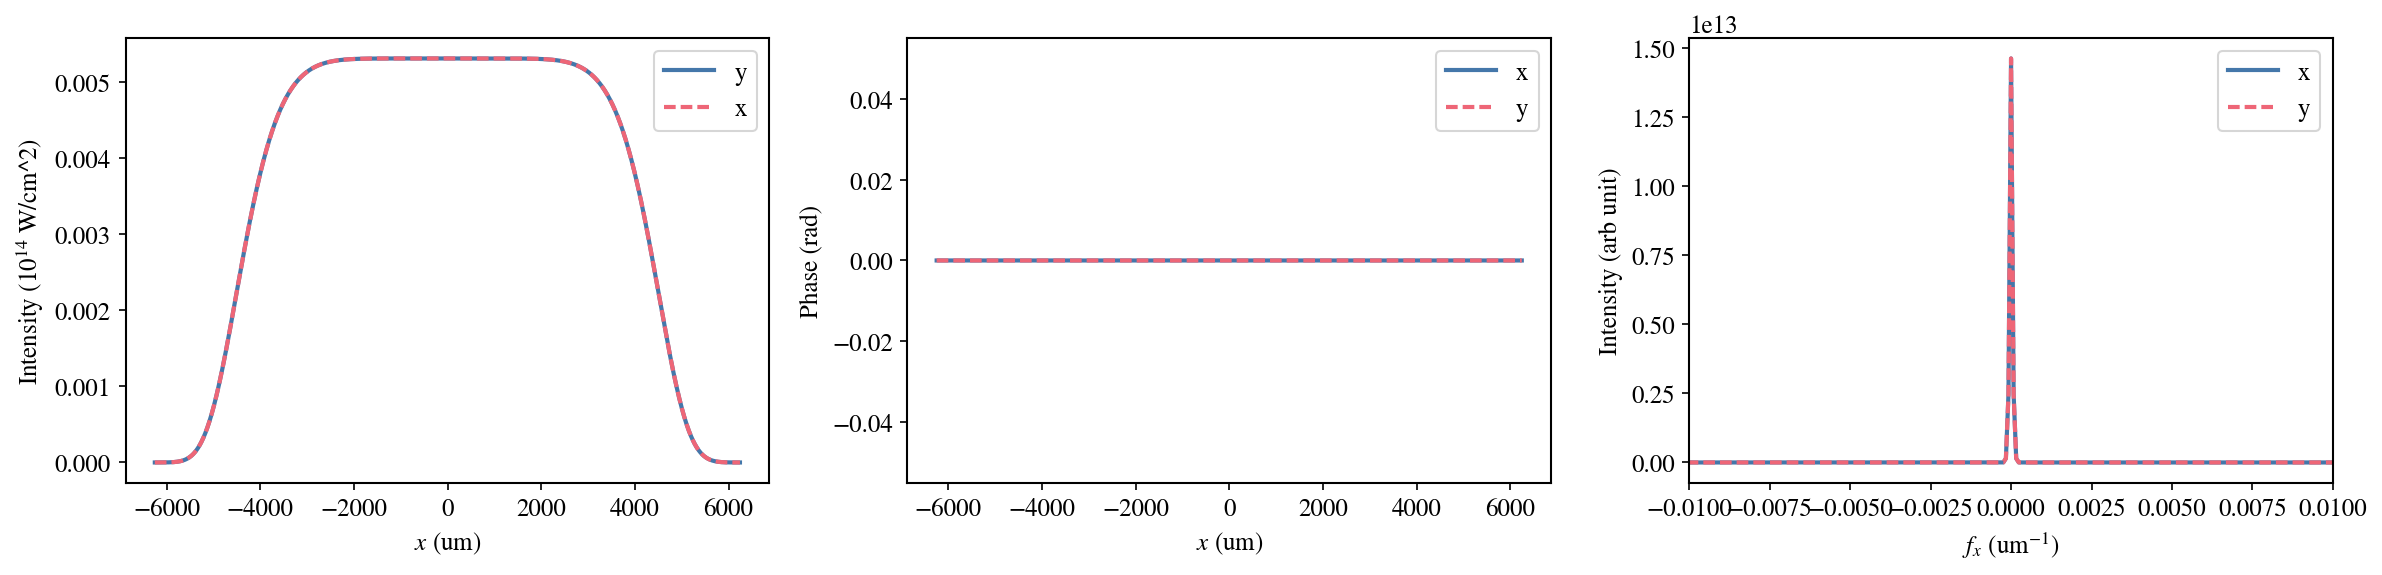

In [2]:
#Start with G-S algorithm to develop the phase mask
Nx = 2**11
X = 1.25e4
n = 8
w0 = 0.5e4
f = 5e4

beamParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'lam' : lam,
              'path' : path,
              'name' : 'Input_beam',
              'threads' : 20,
              'cyl' : True,
              'load' : False,
              'E0' : 2,
              'waist' : w0,
              'order' : n}

# Super Gaussian for simulation
beam_in = laserbeam.SuperGaussianLaser(beamParams)
beam_in.plot_current_field(flim=[-0.01, 0.01])

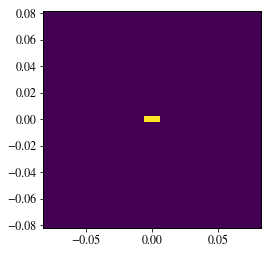

In [3]:
w_x = 500
w_y = 200
w_fx = w_x/(2*lam*f)
w_fy = w_y/(2*lam*f)
fx, fy = beam_in.get_f()
fx = fftshift(fx)
fy = fftshift(fy)
target = np.zeros((Nx, Nx), dtype='double')
sel_x = abs(fx[:, None]) < w_fx
sel_y = abs(fy[None, :]) < w_fy
sel = sel_x*sel_y
target[sel] = 1.0
plt.imshow(beam_in.prep_data(target), extent=[fx[0], fx[-1], fy[0], fy[-1]])
plt.show()
target = fftshift(target)

In [4]:
def plot_field(e):
    magnitude = abs(e)
    phase = np.angle(e)


    ext = [-X/2, X/2, -X/2, X/2]
    plt.figure(figsize=(10, 4), dpi=150)
    plt.subplot(121)
    plt.imshow(beam_in.prep_data(magnitude), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Intensity ($10^{14}$ W/cm^2)')
    plt.xlabel(r'$x$ (um)')
    plt.ylabel(r'$y$ (um)')

    plt.subplot(122)
    plt.imshow(np.unwrap(np.unwrap(beam_in.prep_data(phase), axis=0), axis=1), aspect='auto', extent=ext, cmap='viridis')
    cb = plt.colorbar()
    cb.set_label(r'Phase (rad)')
    plt.xlabel(r'$x$ (um)')
    plt.ylabel(r'$y$ (um)')

    plt.tight_layout()
    plt.show()

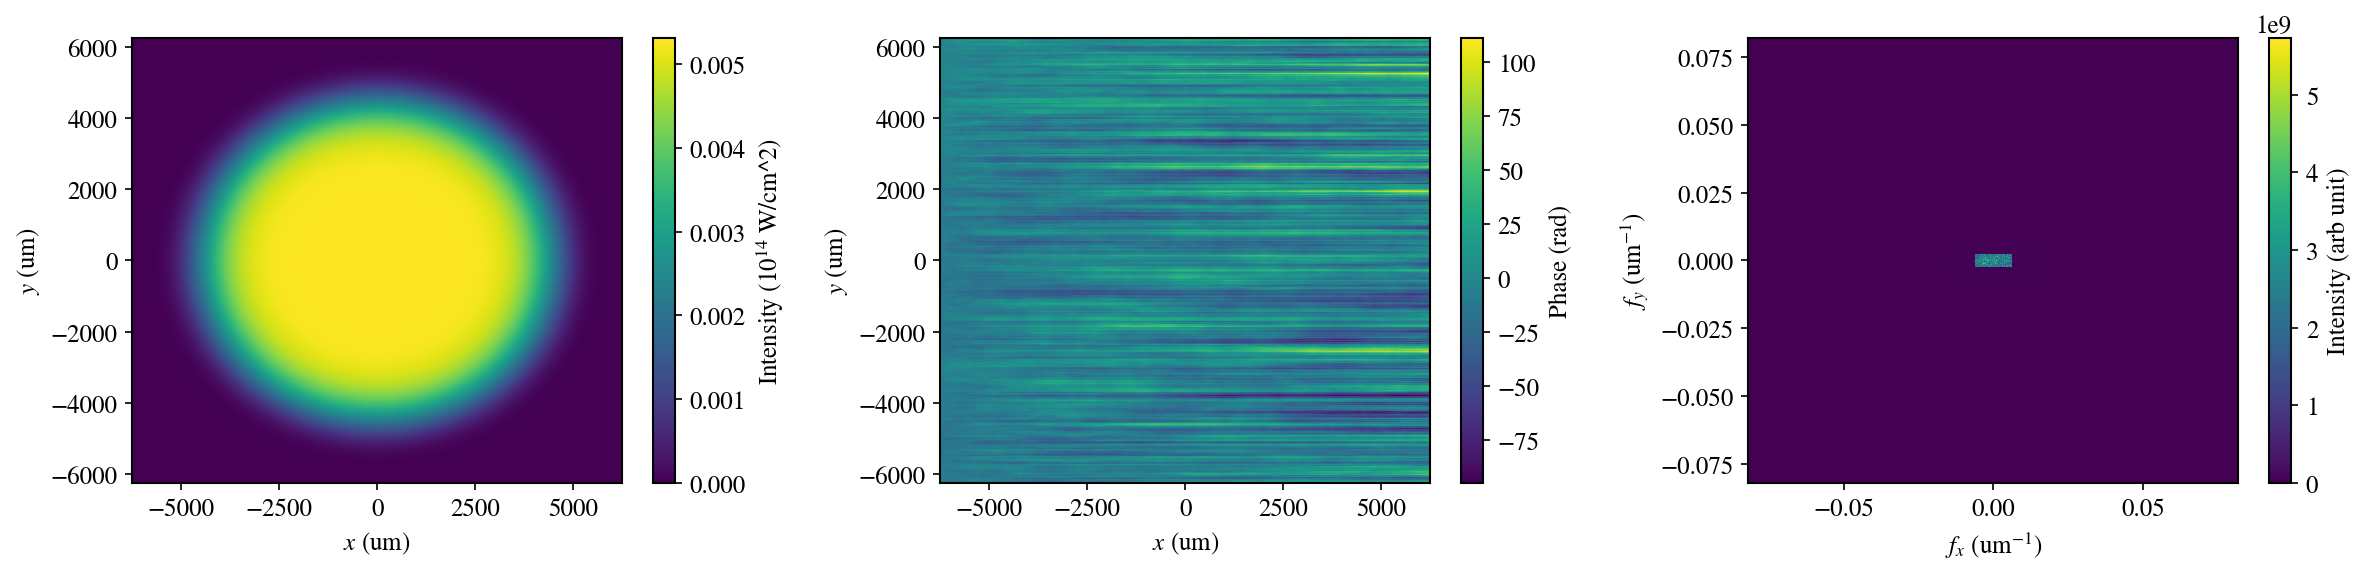

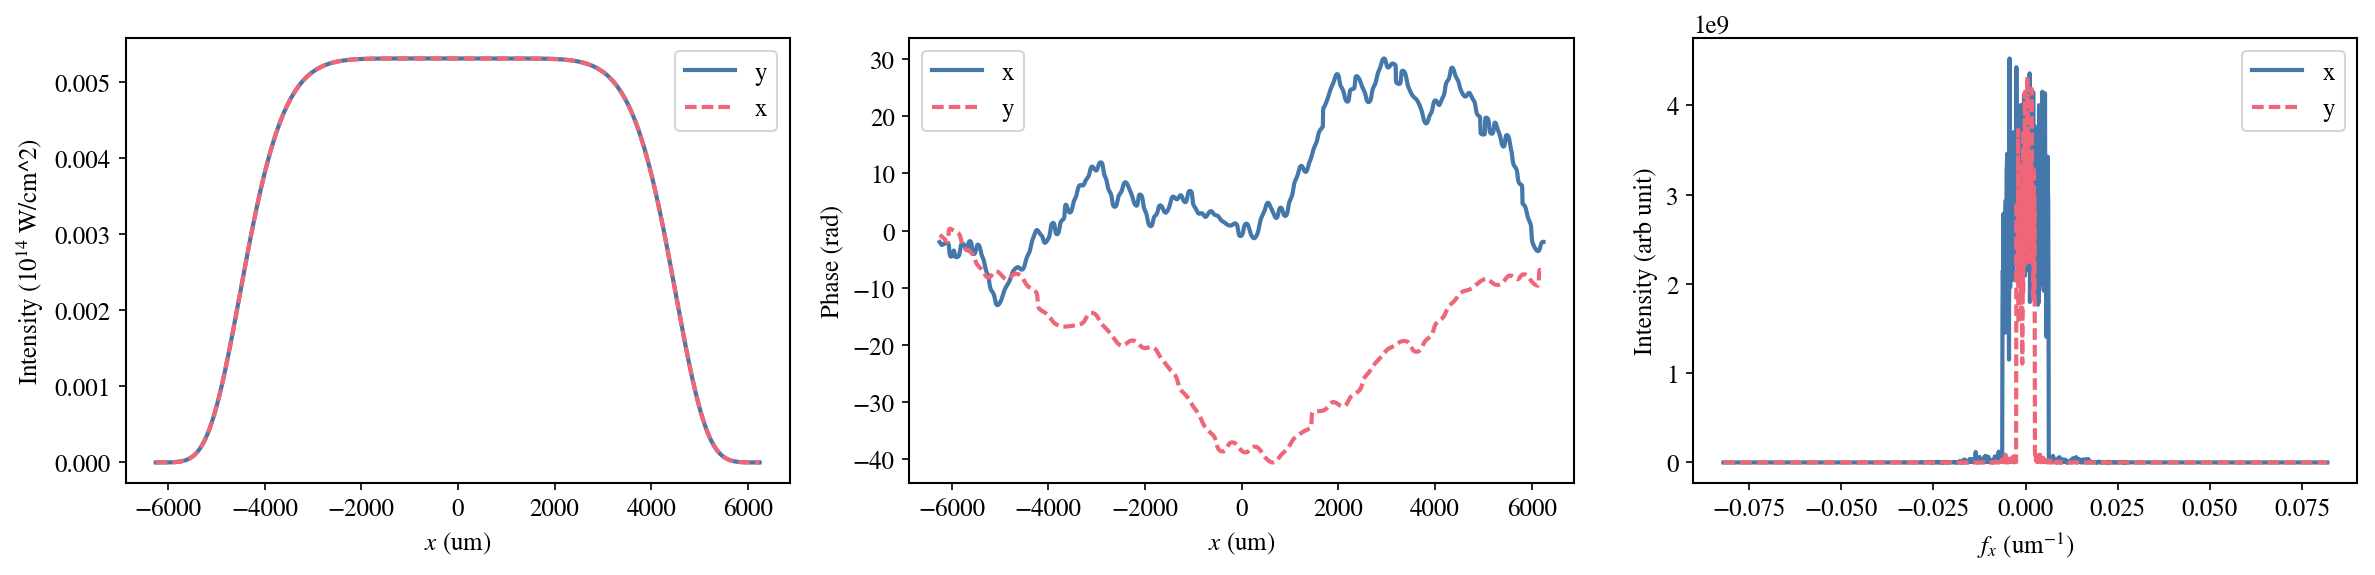

In [5]:
M = 500
initial = abs(beam_in.e)
multi = np.sum(beam_in.intensity_from_field(initial))/np.sum(beam_in.intensity_from_field(target))
target = np.sqrt(multi)*target*Nx
b = initial
c = np.zeros((Nx, Nx))
conv = np.zeros(M)
for i in range(M):
    a = beam_in.fft(b)
    a = target*np.exp(1j*np.angle(a))
    b = beam_in.ifft(a)
    angle = np.angle(b)
    conv[i] = np.sqrt(np.average((c - angle)**2, weights=initial))
    c = angle
    b = initial*np.exp(1j*angle)
beam_in.e = b
beam_in.plot_current_field()

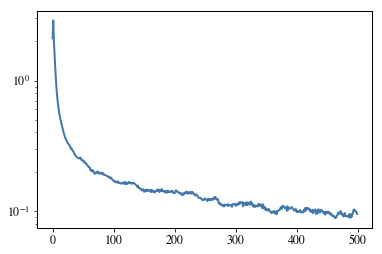

In [6]:
plt.plot(conv)
plt.yscale('log')
plt.show()

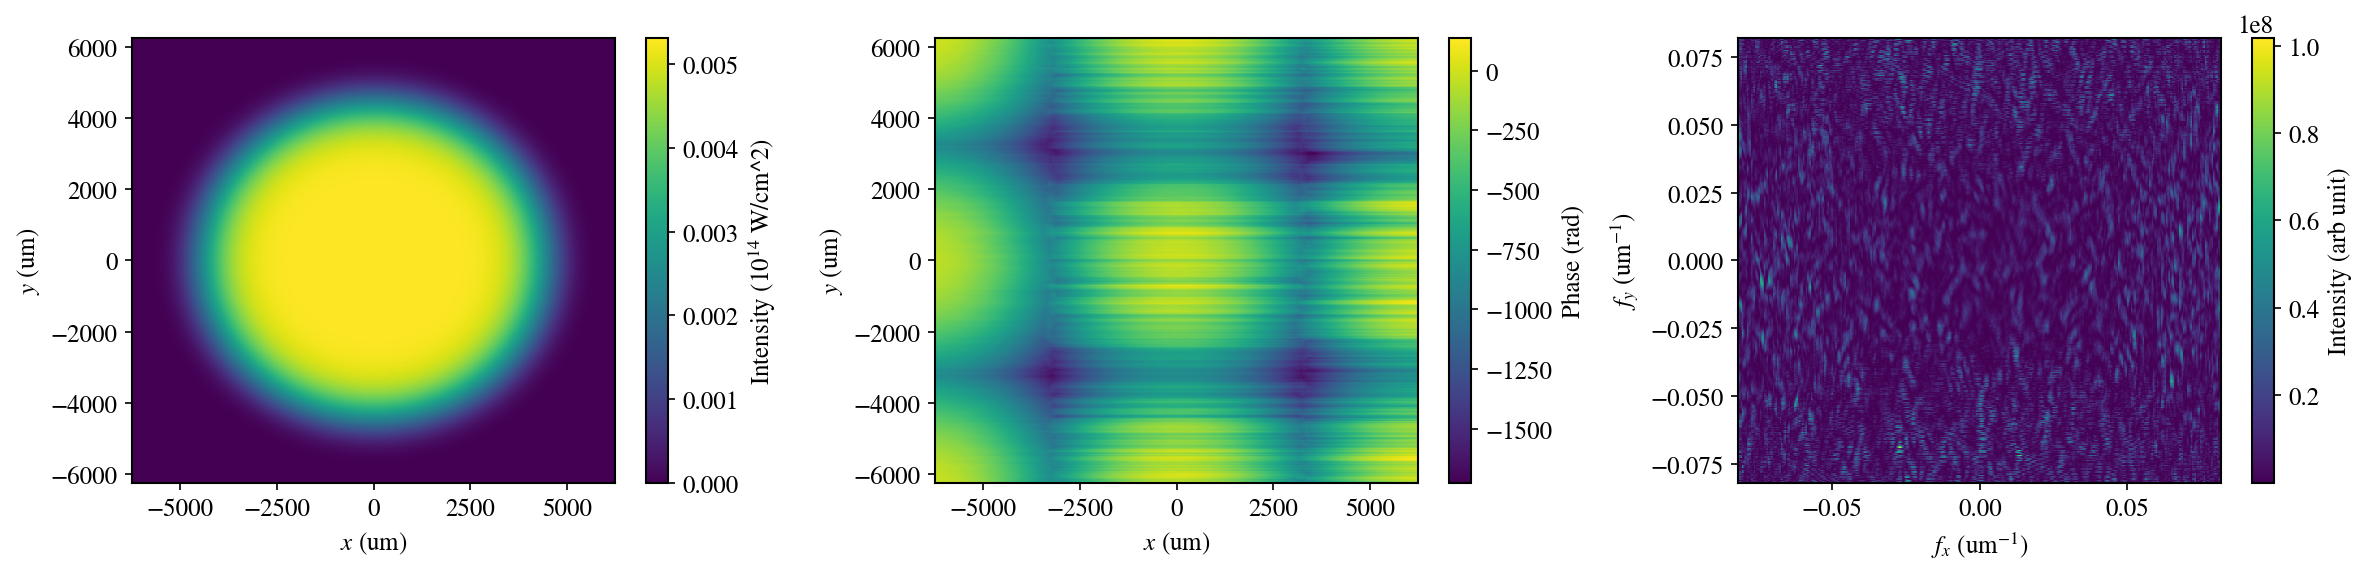

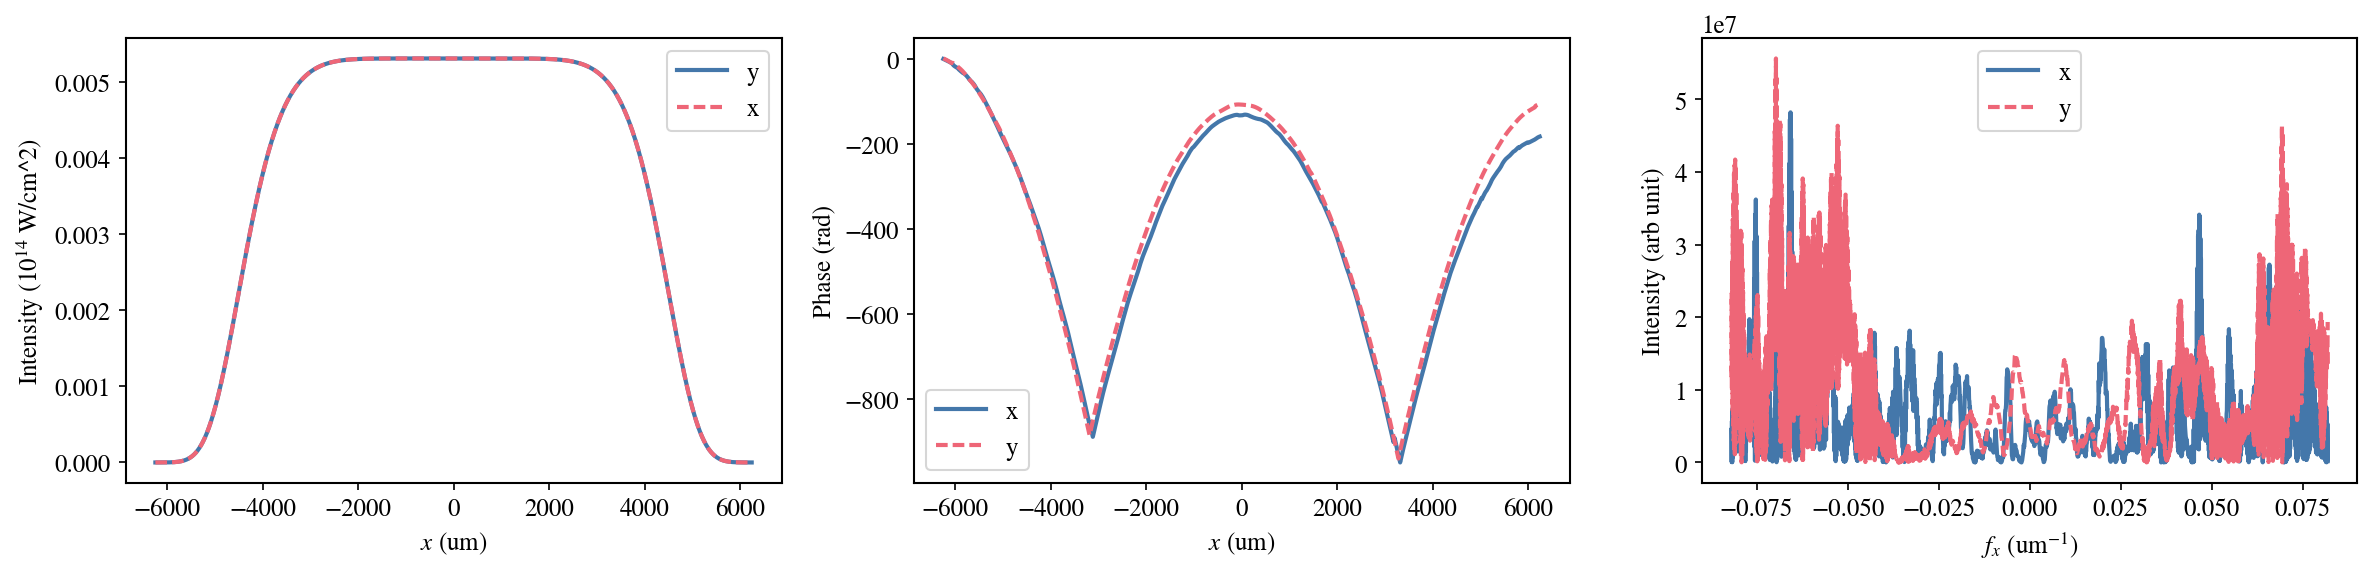

In [7]:
lensParams = {'Nx' : Nx,
              'Ny' : Nx,
              'X' : X,
              'Y' : X,
              'path' : path,
              'name' : 'Spherical_Lens',
              'lam' : lam,
              'f' : f,
              'load' : False}
lens = optic.SphericalLens(lensParams)
interactions.beam_phase(beam_in, lens)
beam_in.plot_current_field()

In [8]:
# Propagate the beam through a lens and see the intensity at the focal spot
beam_in.propagate(f, 1.0)

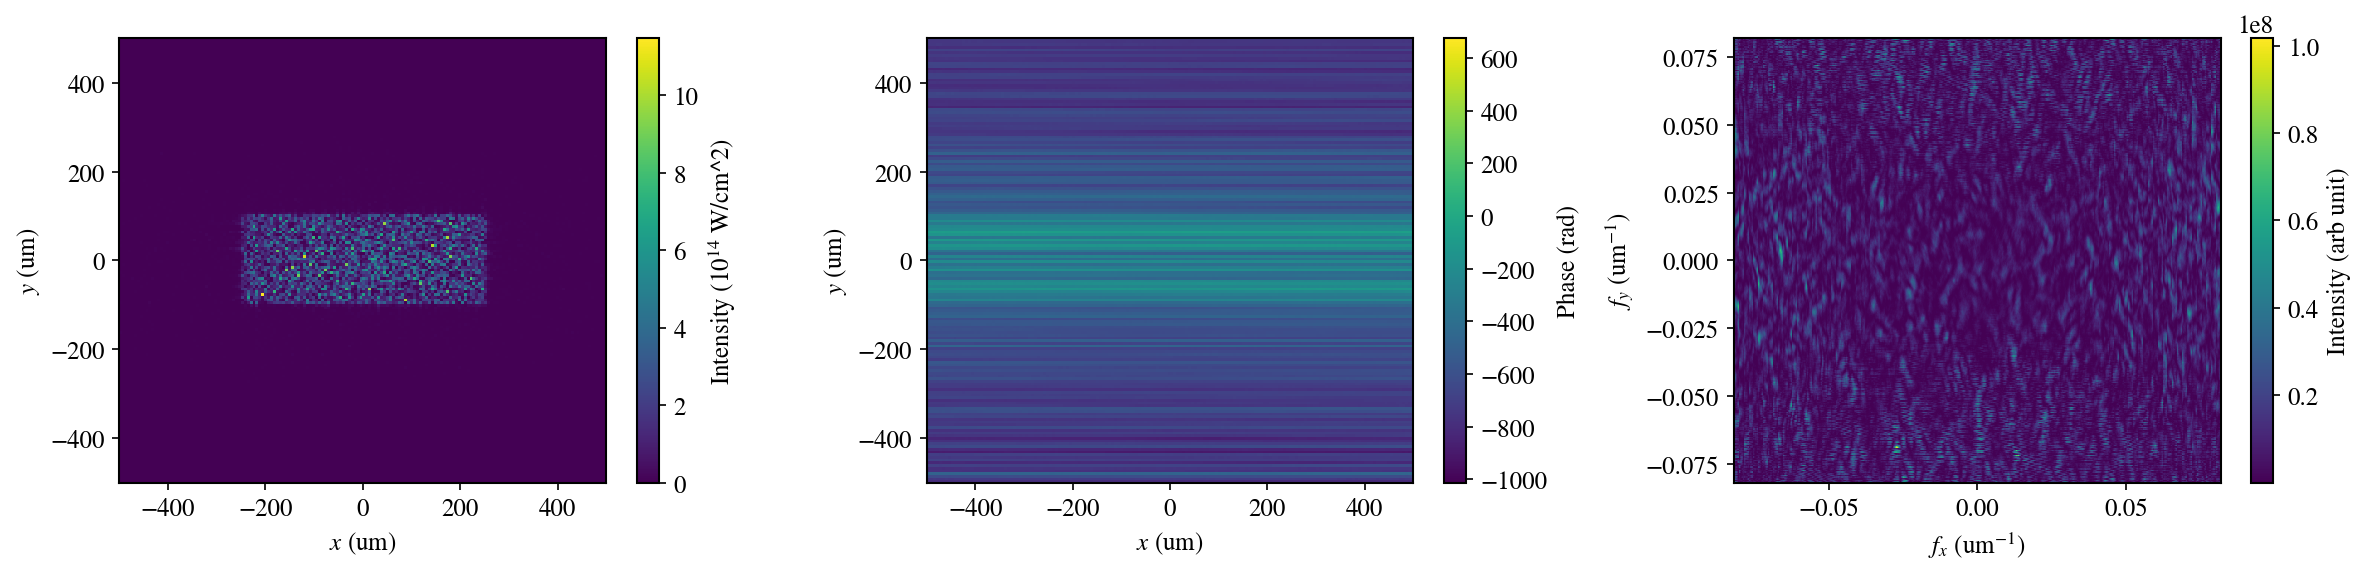

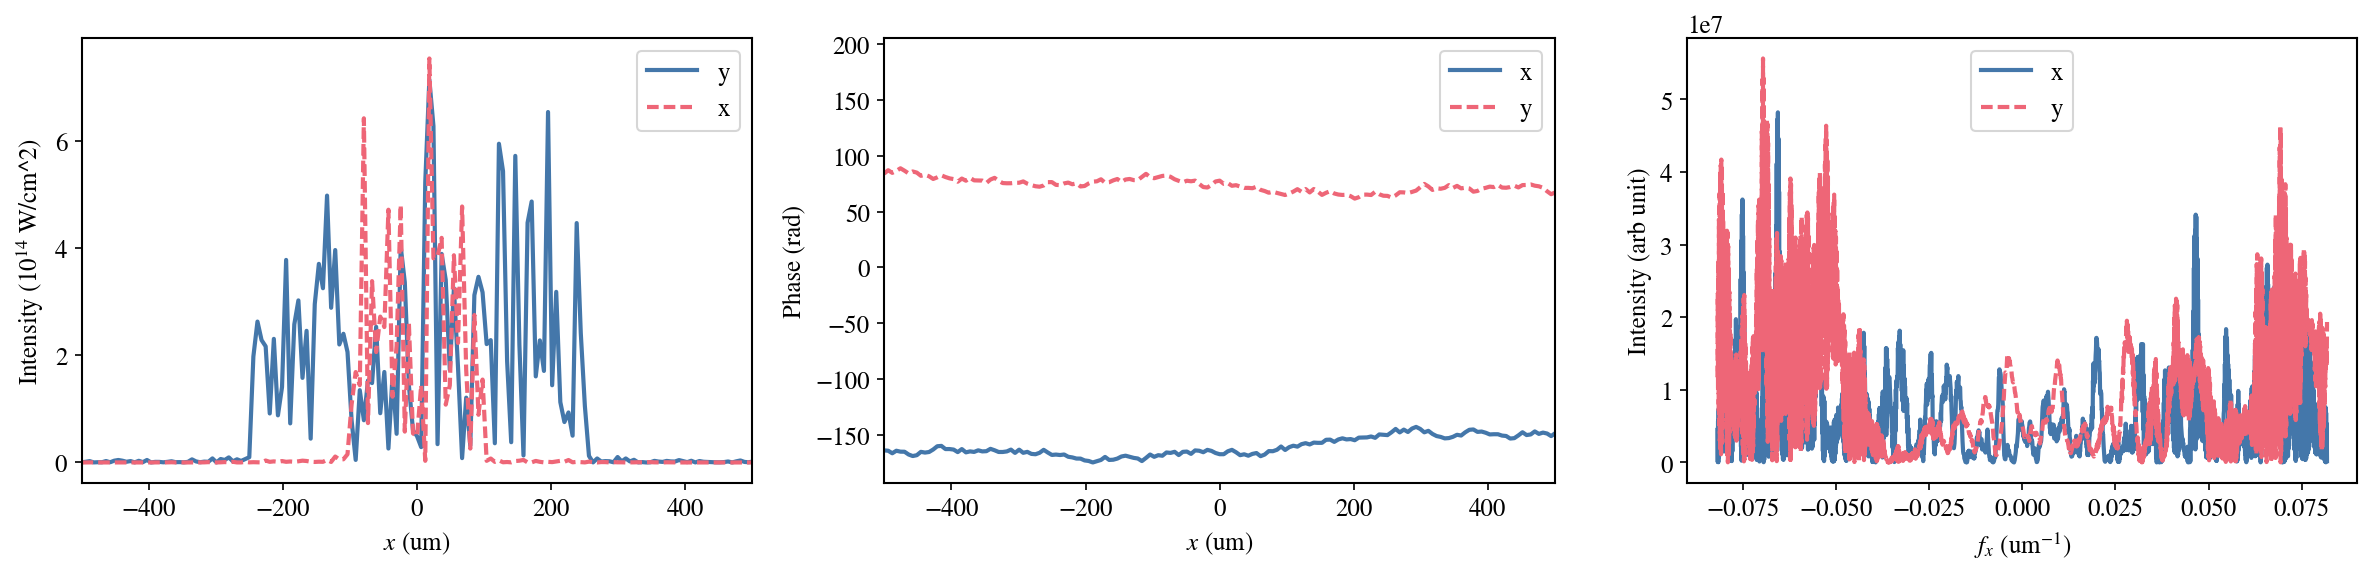

In [9]:
beam_in.plot_current_field(xlim=[-500, 500])

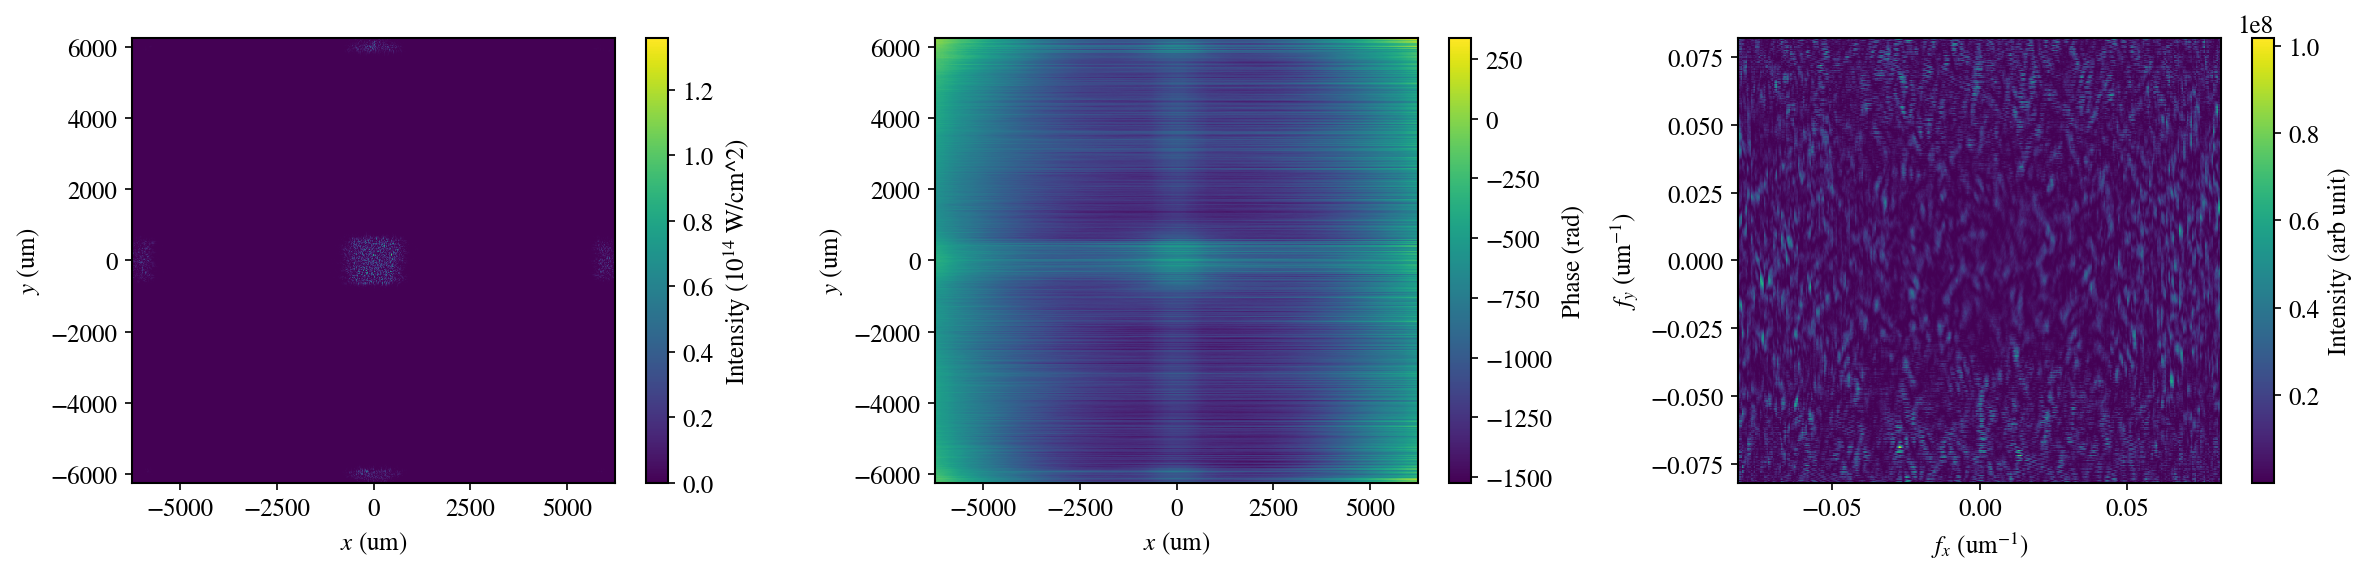

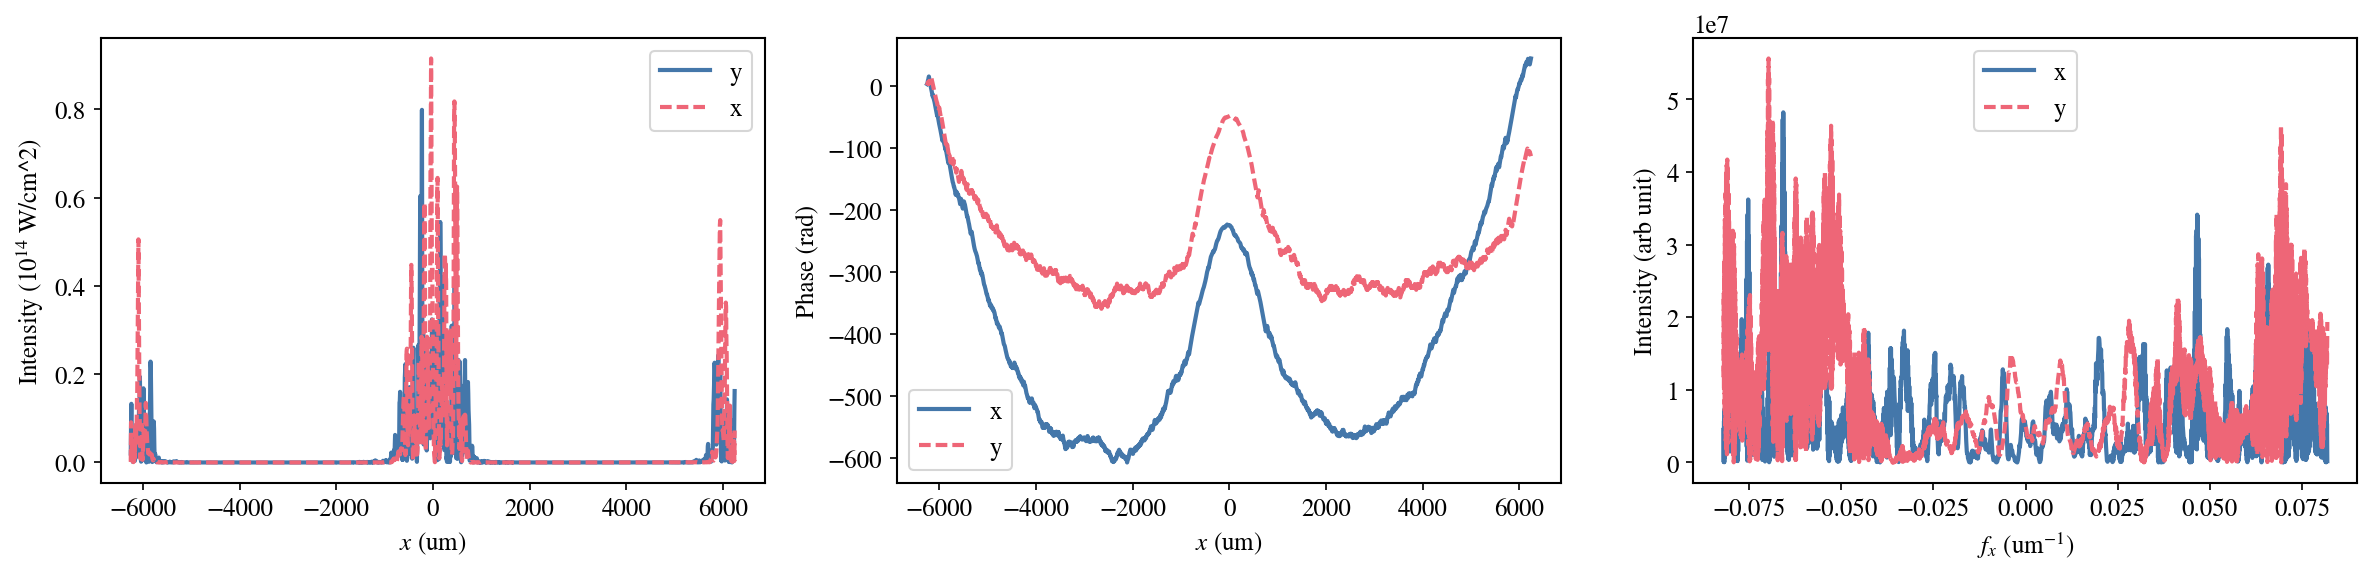

In [10]:
# Propagate to the start of the refraction simulation
Z = 20e3
beam_in.propagate(-Z/2, 1.0)
beam_in.plot_current_field()

In [11]:
n0 = 3.5e16
Nz = 200
atom = ionization.Ar
z = np.linspace(0, Z, Nz)
pulseParams = {
    'Nt' : 2**6,
    'Nx' : Nx,
    'Ny' : Nx,
    'X' : X,
    'Y' : X,
    'T' : 3*tau,
    'lam' : lam,
    'path' : path,
    'load' : False,
    'threads' : 20,
    'cyl' : True,
    'tau' : tau,
    'name' : 'Refracted_Pulse',
    'E0' : 1.0
}

plasmaParams = {
    'Nx' : Nx,
    'Ny' : Nx,
    'Nz' : Nz,
    'X' : X,
    'Y' : X,
    'Z' : Z,
    'atom' : atom,
    'path' : path,
    'load' : False,
    'cyl' : False,
    'name' : 'Refracted_Plasma',
    'n0' : n0/1e17
}
pulse = laserpulse.Pulse(pulseParams)
t = pulse.t
e = beam_in.e*np.exp(-t[:, None, None]**2*np.pi/(2*pulse.tau**2))
pulse.initialize_field(e)

In [12]:
print('Initial pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
helium = plasma.UniformPlasma(plasmaParams)

interactions.pulse_plasma_energy(pulse, helium, 0.0, 0.0)
print('Final pulse energy %0.2fmJ' % (pulse.pulse_energy()*1e3))
e = np.zeros((Nz, Nx), dtype='complex128')
ne = np.zeros((Nz, Nx, Nx))
for i in range(0, Nz-1):
    ne[i, :, :] = helium.load_plasma_density(i)[0]
for i in range(Nz):
    e[i, :] = pulse.load_field(i)[0][int(pulseParams['Nt']/2), :]
I = ionization.intensity_from_field(e)
ne = ne*1e17

Initial pulse energy 22.24mJ
Final pulse energy 22.22mJ


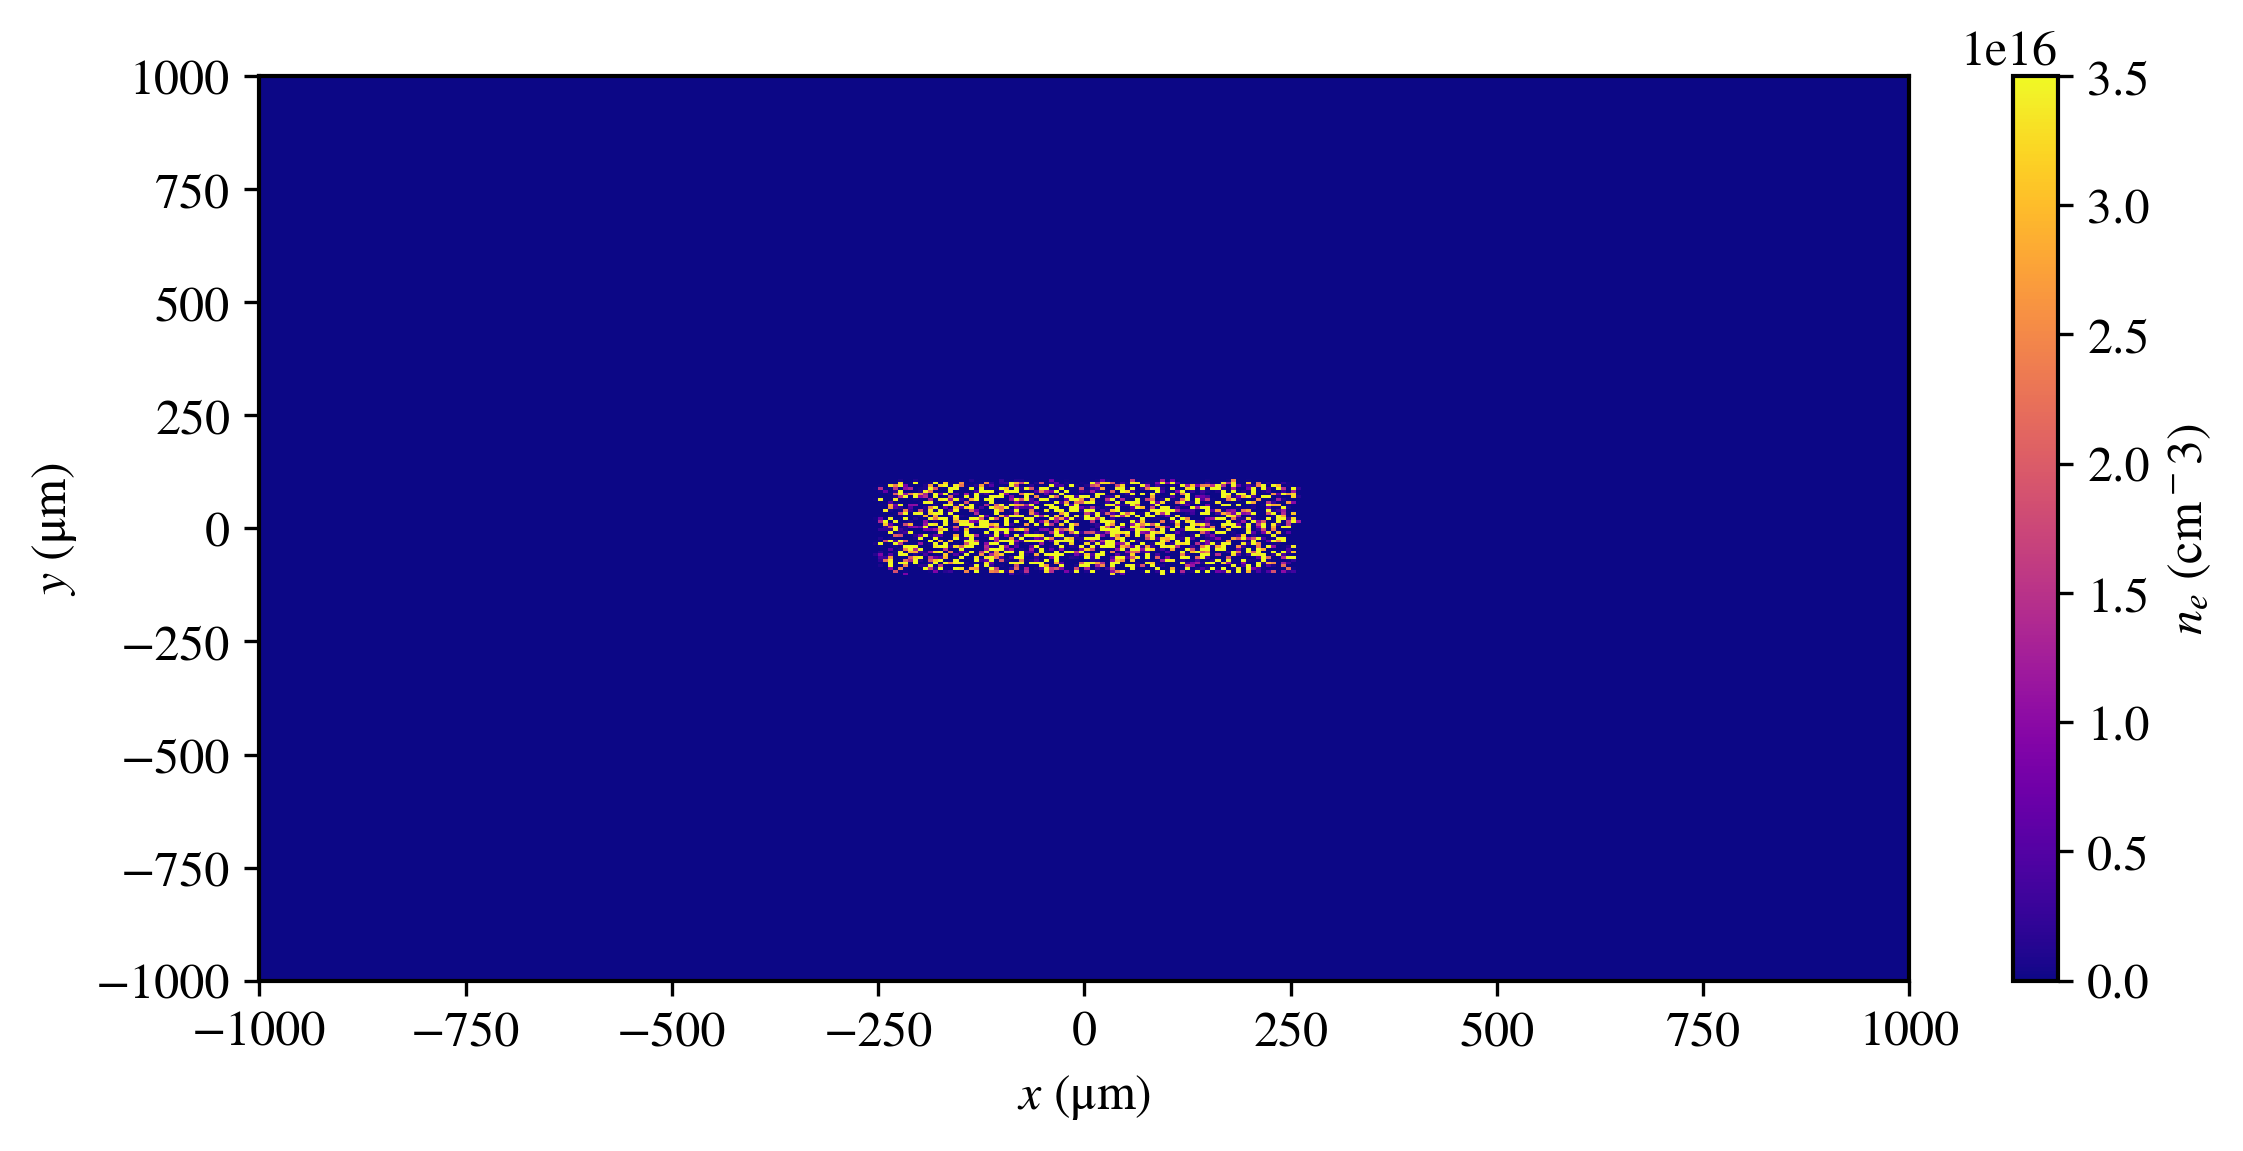

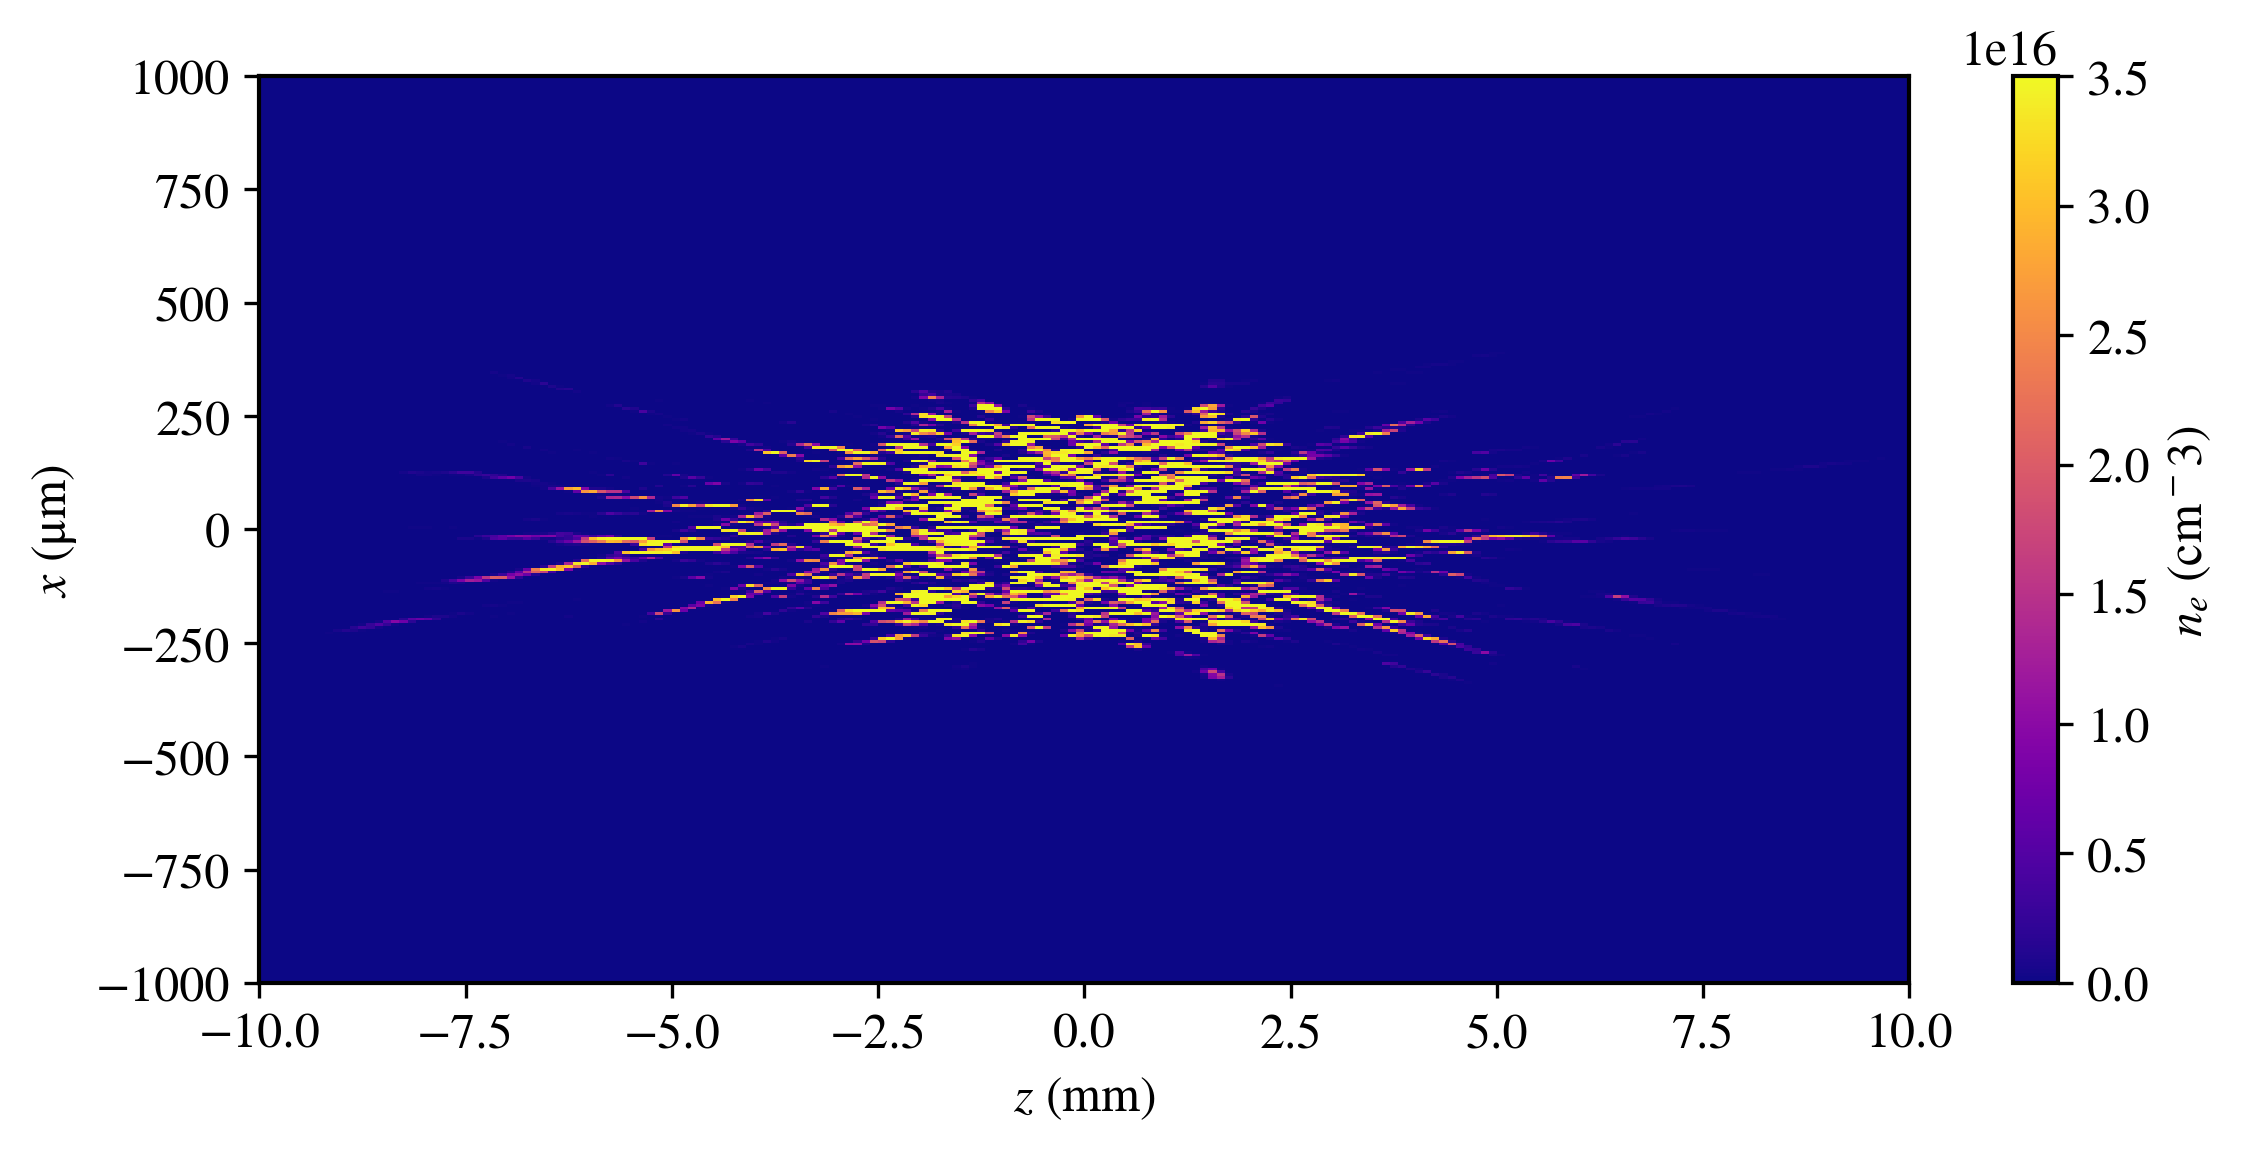

In [13]:
ext = [-X/2, X/2, -X/2, X/2]
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(np.flipud(np.transpose(ne[int(Nz/2), :, :])), aspect='auto', extent=ext, cmap='plasma')
cb = plt.colorbar()
cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
plt.xlabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylabel(r'$y$ ($\mathrm{\mu m}$)')
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.tight_layout()
plt.show()

ext = [-Z/2e3, Z/2e3, -X/2, X/2]
plt.figure(figsize=(8, 4), dpi=300)
plt.imshow(np.flipud(np.transpose(ne[:, :, int(Nx/2)])), aspect='auto', extent=ext, cmap='plasma')
cb = plt.colorbar()
cb.set_label(r'$n_e$ ($\mathrm{cm^-3}$)')
plt.xlabel('$z$ (mm)')
plt.ylabel(r'$x$ ($\mathrm{\mu m}$)')
plt.ylim(-1000, 1000)
plt.tight_layout()
plt.show()